# Fonctions pour le calcul avec le maximum de la vraisemblance

## Lecture et nettoyage des données (code fourni)

In [2]:
using CSV, DataFrames, Gadfly, Distributions, StatsBase, GaussianMixtures

┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly C:\Users\Mjk\.julia\packages\Gadfly\09PWZ\src\mapping.jl:228


In [3]:
train = CSV.read("ODtrain.csv")
n = size(train,1)
p = size(train,2)
dropmissing!(train, disallowmissing=true)
str_mode = ["Voiture", "Transport Collectif", "Hybride", "Actif", "Autre"]

d = Array{String}(undef,n)

for i=1:length(str_mode)
   
    ind = train[:D_Mode] .== i
    d[ind] .= str_mode[i] 
    
end

train[:D_Mode_str] = d

categorical!(train, :D_Mode_str);

## Analyse des distributions des données

Ici on peut changer les valeurs des trois premières variables pour tenter de trouver la bonne distribution à associer à une variable quelconque.

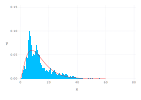

In [4]:
dep = 2;
sym = :M_dist_centre
dist = Gamma

voi = train[train[:D_Mode] .== dep, :];
fd = fit_mle(dist, voi[sym]);
xx = 0:0.1:60;
f = pdf.(fd, xx);
h = layer(x = voi[sym], Geom.histogram(density = true));
f = layer(x = xx, y = f, Geom.line, Theme(default_color="red"));
plot(f, h)

## Fonctions pour le calcul

### Constante

In [5]:
k = 5

5

### Déclaration de types utilisés

In [6]:
struct MelangeNormales
    n::Int64
end

### Fonctions internes ("privées")

In [12]:
function determineMode(index::Int64, dist::Array{Distribution, 2}, columns::Array{Symbol, 1}, testSet::DataFrame)
    # Y Cat(τ)
    τ = fit(Categorical, train[:D_Mode])
    # P(Y = i | X = dist) = p[i]
    p = Array{Float64}(undef, k)
    max = 1
    for i=1:k
        p[i] = log(pdf(τ, i))
        nVarExpl = size(dist, 1)
        for j=1:nVarExpl
           p[i] += log(pdf(dist[j, i], testSet[columns[j]][index]))
        end
        if p[max] < p[i]
            max = i
        end
    end
    return max
end
function validate(estimates::Array{Int64}, realValue::Array{Int64})
    n = length(realValue)
    nEach = [0, 0, 0, 0, 0]
    right = [0, 0, 0, 0, 0]
    for i=1:n
        nEach[realValue[i]] += 1
        if estimates[i] == realValue[i]
            right[realValue[i]] += 1
        end
    end
    for i=1:k
       print(str_mode[i], " : ", right[i]/nEach[i]*100, "%\n" ) 
    end
    print("Total : ", sum(right)/n*100, "%\n" ) 
end
struct TestSet
    train::DataFrame
    test::DataFrame
end
function getTestSet(initialSet::DataFrame)
    n = length(initialSet[:D_Mode])
    nTest = convert(Int64, round(0.20 * n))
    index = rand(0:n-nTest+1)
    return TestSet(vcat(initialSet[1:index-1, :], initialSet[index+nTest:n, :]), initialSet[index:index+nTest-1, :])
    
    a = [1,2,3]
    b= view(a, 1:2)
    c= vcat(view(a, 1:1), view(a, 3:3))
end
function getEstimation(distType::Array{Any, 2}, columns::Array{Symbol, 1}, set::TestSet)
    # Maximum de la vraisemblance pour estimer
    nVariablesExpl = length(columns)
    dist = Array{Distribution}(undef, nVariablesExpl, k)
    for varExpl=1:nVariablesExpl
        for mode=1:k
            trainT = set.train[set.train[:D_Mode] .== mode, :];
            if typeof(distType[varExpl, mode]) == MelangeNormales
                gmm = GMM(distType[varExpl, mode].n, trainT[Symbol(columns[varExpl])]; method=:kmeans, nInit=100, nIter=20)
                dist[varExpl, mode] = MixtureModel(gmm)
            else
                # fit_mle retourne les estimateurs avec le maximum de la vraisemblance.
                dist[varExpl, mode] = fit_mle(distType[varExpl, mode], trainT[Symbol(columns[varExpl])])
            end
        end
    end
    amount = length(set.test[:IPERE])
    res= Array{Int64}(undef, amount)
    for i=1:amount
       res[i] = determineMode(i, dist, columns, set.test) 
    end
    return res
end

getEstimation (generic function with 2 methods)

### Fonction "publique"

In [13]:
function getPercentRight(distType::Array{Any, 2}, columns::Array{Symbol, 1})
    set = getTestSet(train)
    estimation = getEstimation(distType, columns, set)
    validate(estimation, set.test[:D_Mode])
end
function generateSubmission(distType::Array{Any, 2}, columns::Array{Symbol, 1})
    test = CSV.read("ODtest.csv")
    submission = test[:, [:IPERE]]
    set = TestSet(train, test)
    estimation = getEstimation(distType, columns, set)
    submission = DataFrame(IPERE = test[:IPERE],D_MODE = estimation)
    CSV.write("Submission.csv", submission)
end

generateSubmission (generic function with 2 methods)

### Exemple

Ici, on estime que la variable P_PERMIS est distribuée selon une loi Catégorielle.
On pense la même chose pour la variable P_STATUT.
Pour la variable M_dist_centre, on pense plutôt qu'elle suit une loi Gamma.

Pour les trois variables, nous avons donné la même distribution peut-importe la valeur de Y.
Cependant, si nous pensions que lorsque Y = 3, la variable M_dist_centre est distribuée selon une loi normale, nous aurions pu écrire:
Gamma Gamma Normal Gamma Gamma

Les fonctions ci-dessus séparent l'échantillon train en deux portions (4/5 train, 1/5 test). Cette séparation change à toutes les fois où l'algorithme est roulé.
Le résultat de l'appel à getPercentRight est séparé selon le mode de transport.

In [36]:
getPercentRight([
        [Categorical Categorical Categorical Categorical Categorical];
        [Categorical Categorical Categorical Categorical Categorical];
        [MelangeNormales(10) MelangeNormales(7) MelangeNormales(7) MelangeNormales(8) MelangeNormales(9)]
        #[MelangeNormales(20) MelangeNormales(15) MelangeNormales(15) MelangeNormales(16) MelangeNormales(17)]
        ], [
        :P_PERMIS,
        :P_STATUT,
        :M_dist_centre
        ])

┌ Info: Initializing GMM, 10 Gaussians LinearAlgebra.diag covariance 1 dimensions using 28824 data points
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:78


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.151810e+04
      1       2.748526e+04      -4.032841e+03 |       10
      2       2.674490e+04      -7.403672e+02 |       10
      3       2.645172e+04      -2.931715e+02 |        9
      4       2.630517e+04      -1.465495e+02 |        9
      5       2.619382e+04      -1.113546e+02 |        9
      6       2.611189e+04      -8.193159e+01 |        8
      7       2.604401e+04      -6.787965e+01 |        9
      8       2.598368e+04      -6.032430e+01 |        8
      9       2.593163e+04      -5.205411e+01 |        6
     10       2.589046e+04      -4.117035e+01 |        7
     11       2.586157e+04      -2.888654e+01 |        6
     12       2.584070e+04      -2.087766e+01 |        6
     13       2.582294e+04      -1.775871e+01 |        6
     14       2.580634e+04      -1.659415e+01 |        7
     15       2.579483e+04      -1.151563e+01 |        

┌ Info: K-means with 10000 data points using 71 iterations
│ 500.0 data points per parameter
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:139
┌ Info: Running 20 iterations EM on diag cov GMM with 10 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:243
┌ Info: iteration 1, average log likelihood -3.885124
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -3.860798
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -3.854417
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -3.851700
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -3.850275
└ @ GaussianMixtures C

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.

┌ Info: iteration 18, average log likelihood -3.847340
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 19, average log likelihood -3.847296
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 20, average log likelihood -3.847256
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: EM with 28824 data points 20 iterations avll -3.847256
│ 993.9 data points per parameter
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: Initializing GMM, 7 Gaussians LinearAlgebra.diag covariance 1 dimensions using 11816 data points
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:78


758104e+04
      1       2.057567e+04      -7.005372e+03 |        7
      2       1.950122e+04      -1.074453e+03 |        7
      3       1.898700e+04      -5.142166e+02 |        7
      4       1.872432e+04      -2.626768e+02 |        7
      5       1.858569e+04      -1.386383e+02 |        7
      6       1.845993e+04      -1.257531e+02 |        7
      7       1.836802e+04      -9.191201e+01 |        7
      8       1.831467e+04      -5.335175e+01 |        7
      9       1.826132e+04      -5.334354e+01 |        7
     10       1.821341e+04      -4.791677e+01 |        6
     11       1.817662e+04      -3.679000e+01 |        5
     12       1.814995e+04      -2.666676e+01 |        6
     13       1.813560e+04      -1.435168e+01 |        6
     14       1.812451e+04      -1.108648e+01 |        6
     15       1.811186e+04      -1.264913e+01 |        7
     16       1.810178e+04      -1.008897e+01 |        5
     17       1.809619e+04      -5.582745e+00 |        5
     18       1.8093

┌ Info: K-means with 7000 data points using 45 iterations
│ 500.0 data points per parameter
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:139
┌ Info: Running 20 iterations EM on diag cov GMM with 7 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:243
┌ Info: iteration 1, average log likelihood -3.359596
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -3.336240
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -3.329667
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -3.326726
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -3.325078
└ @ GaussianMixtures C:\

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0 

┌ Info: iteration 11, average log likelihood -3.321375
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 12, average log likelihood -3.321039
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 13, average log likelihood -3.320732
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 14, average log likelihood -3.320447
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 15, average log likelihood -3.320182
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 16, average log likelihood -3.319935
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 17, average log likelihood -3.319705
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71

      9.802348e+03
      1       6.538202e+03      -3.264146e+03 |        7
      2       6.372034e+03      -1.661688e+02 |        6
      3       6.318073e+03      -5.396101e+01 |        6
      4       6.286654e+03      -3.141888e+01 |        6
      5       6.255795e+03      -3.085862e+01 |        6
      6       6.248414e+03      -7.380944e+00 |        6
      7       6.246559e+03      -1.854874e+00 |        6
      8       6.242321e+03      -4.238525e+00 |        4
      9       6.242161e+03      -1.598561e-01 |        3
     10       6.241798e+03      -3.633192e-01 |        2
     11       6.241313e+03      -4.841640e-01 |        3
     12       6.240640e+03      -6.735693e-01 |        2
     13       6.240496e+03      -1.434577e-01 |        2
     14       6.240438e+03      -5.807060e-02 |        0
     15       6.240438e+03       0.000000e+00 |        0
K-means converged with 15 iterations (objv = 6240.43825274443)


┌ Info: K-means with 1680 data points using 15 iterations
│ 120.0 data points per parameter
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:139
┌ Info: Running 20 iterations EM on diag cov GMM with 7 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:243
┌ Info: iteration 1, average log likelihood -3.711983
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -3.689146
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -3.682874
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -3.680215
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -3.678825
└ @ GaussianMixtures C:\

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.198333e+04
      1       2.

┌ Info: iteration 12, average log likelihood -3.676349
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 13, average log likelihood -3.676244
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 14, average log likelihood -3.676155
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 15, average log likelihood -3.676077
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 16, average log likelihood -3.676008
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 17, average log likelihood -3.675946
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 18, average log likelihood -3.675889
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71

714169e+04      -4.841640e+03 |        8
      2       2.641711e+04      -7.245793e+02 |        8
      3       2.592231e+04      -4.947977e+02 |        8
      4       2.541469e+04      -5.076290e+02 |        8
      5       2.501184e+04      -4.028451e+02 |        8
      6       2.469354e+04      -3.182999e+02 |        8
      7       2.427884e+04      -4.147054e+02 |        8
      8       2.390940e+04      -3.694380e+02 |        8
      9       2.365289e+04      -2.565065e+02 |        8
     10       2.345990e+04      -1.929861e+02 |        8
     11       2.333886e+04      -1.210447e+02 |        8
     12       2.321881e+04      -1.200475e+02 |        8
     13       2.311487e+04      -1.039470e+02 |        8
     14       2.302457e+04      -9.029417e+01 |        8
     15       2.295924e+04      -6.533112e+01 |        7
     16       2.287700e+04      -8.224072e+01 |        7
     17       2.276918e+04      -1.078156e+02 |        8
     18       2.264956e+04      -1.196253e+02 |

┌ Info: K-means with 6680 data points using 53 iterations
│ 417.5 data points per parameter
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:139
┌ Info: Running 20 iterations EM on diag cov GMM with 8 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:243
┌ Info: iteration 1, average log likelihood -3.563065
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -3.547263
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -3.543723
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -3.542450
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -3.541854
└ @ GaussianMixtures C:\

  Iters               objv        objv-change | affected 
-------------------------------------------------------------


┌ Info: iteration 6, average log likelihood -3.541511
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 7, average log likelihood -3.541274
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 8, average log likelihood -3.541084
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 9, average log likelihood -3.540917
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 10, average log likelihood -3.540760
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 11, average log likelihood -3.540607
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 12, average log likelihood -3.540456
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ I

      0       2.025375e+04
      1       1.446868e+04      -5.785064e+03 |        9
      2       1.395947e+04      -5.092074e+02 |        8
      3       1.375983e+04      -1.996486e+02 |        8
      4       1.363008e+04      -1.297420e+02 |        7
      5       1.357110e+04      -5.898237e+01 |        5
      6       1.351787e+04      -5.323342e+01 |        6
      7       1.348637e+04      -3.150081e+01 |        6
      8       1.347959e+04      -6.773213e+00 |        6
      9       1.347669e+04      -2.902436e+00 |        4
     10       1.347427e+04      -2.421097e+00 |        6
     11       1.347282e+04      -1.448586e+00 |        5
     12       1.347085e+04      -1.971330e+00 |        6
     13       1.346948e+04      -1.374277e+00 |        7
     14       1.346635e+04      -3.121861e+00 |        4
     15       1.346308e+04      -3.271772e+00 |        3
     16       1.346284e+04      -2.438512e-01 |        3
     17       1.346222e+04      -6.149358e-01 |        4
    

┌ Info: K-means with 4022 data points using 21 iterations
│ 223.4 data points per parameter
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:139
┌ Info: Running 20 iterations EM on diag cov GMM with 9 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\train.jl:243
┌ Info: iteration 1, average log likelihood -3.938191
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -3.916912
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -3.910999
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -3.908430
└ @ GaussianMixtures C:\Users\Mjk\.julia\packages\GaussianMixtures\6oHTE\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -3.907052
└ @ GaussianMixtures C:\

Voiture : 83.95677472984207%
Transport Collectif : 34.79335923701872%
Hybride : 0.0%
Actif : 27.438307873090483%
Autre : 76.1070110701107%
Total : 62.89701999245567%


In [10]:
generateSubmission([
        [Categorical Categorical Categorical Categorical Categorical];
        [Categorical Categorical Categorical Categorical Categorical];
        [Gamma Gamma Gamma Gamma Gamma]
        ], [
        :P_PERMIS,
        :P_STATUT,
        :M_dist_centre
        ])

"Submission.csv"